In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

%matplotlib inline

In [5]:
!iconv -f cp1251 -t utf-8 vk_feed.csv -o vk_feed_utf.csv 

iconv: cannot open input file `vk_feed.csv': No such file or directory


In [3]:
data = pd.read_csv('cleaned_data.csv', index_col=0)
data.head()

,text,status,predict_proba,predict,lang
0,ребят краснодар нужны доноры положительная для...,1,1,1,ru
1,волгоград прошу максимальный перепост предыдущ...,1,1,1,ru
2,срочно требуются доноры крови любая цельная кр...,1,1,1,ru
4,анонимно люди крик о помощи срочно а точнее в ...,1,1,1,ru
5,люди крик о помощи срочно а точнее в понедельн...,1,1,1,ru


In [4]:
from langdetect import detect

def detect_language(text):
    try:
        lang = detect(text)
        return lang
    except:
        return '-'

In [5]:
data.groupby(by='lang').count()

,text,status,predict_proba,predict
lang,,,,
ru,26108,26108,26108,26108


In [6]:
data = data[data['lang'] == 'ru']

In [7]:
data.groupby(by='status').count()

,text,predict_proba,predict,lang
status,,,,
0,1836,1836,1836,1836
1,24272,24272,24272,24272


In [8]:
import re
from html2text import html2text

def preprocess(text):
    text = html2text(text)
    text = re.sub('[\W]', ' ', text)
    text = re.sub('_', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('[A-Za-z0-9]', '', text) #removing english
    text = text.lower()
    return text

In [9]:
data['text'] = data['text'].apply(preprocess)

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.snowball import RussianStemmer

class Preprocessor:
    def __init__(self, stemmer, analyser):
        self.stemmer = stemmer
        self.analyser = analyser
        
    def __call__(self, doc):
        return (self.stemmer.stem(w) for w in self.analyser(doc) if len(w) > 3)
    
preporcessor = Preprocessor(RussianStemmer(), CountVectorizer(ngram_range=(1,3)).build_analyzer())

vectorizer = CountVectorizer(stop_words=stopwords.words('russian'), analyzer=preporcessor)
V = vectorizer.fit_transform(data['text'])

print(V.shape)

(26108, 557793)


In [11]:
feature_count = len(vectorizer.vocabulary_)

feature_names = [''] * feature_count

for key, value in vectorizer.vocabulary_.items():
    feature_names[int(value)] = key

In [12]:
y = np.array(data['status'])

In [13]:
from sklearn.cross_validation import StratifiedKFold
import xgboost as xgb

fnames = vectorizer.vocabulary_
dtrain = xgb.DMatrix(data=V, label=y, feature_names=feature_names)
param = {'max_depth':12, 'eta':0.3, 'objective':'binary:logistic'}
num_round = 10

cv = xgb.cv(param, dtrain, num_round, nfold=3, metrics={'error'}, seed = 0)
print(cv)

   test-error-mean  test-error-std  train-error-mean  train-error-std
0         0.041676        0.004155          0.032062         0.004350
1         0.030568        0.001550          0.023328         0.002696
2         0.028193        0.001576          0.021642         0.001093
3         0.026967        0.001648          0.020666         0.000664
4         0.025665        0.001774          0.019114         0.000426
5         0.025281        0.001905          0.017640         0.000775
6         0.025052        0.001723          0.016567         0.000533
7         0.024707        0.001668          0.015954         0.000667
8         0.024056        0.001554          0.014997         0.000802
9         0.023481        0.001784          0.014364         0.000635


In [14]:
model = xgb.train(param, dtrain, num_round)
model.eval(dtrain)

b'[0]\teval-error:0.014861'

In [16]:
data['predict_proba'] = model.predict(dtrain)
data['predict'] = data['predict_proba'] >= 0.5

In [17]:
data.to_csv('cleaned_data.csv')

In [21]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_true = data['status']
fpr, tpr, thresholds = roc_curve(y_true, data['predict_proba'])
auc_score = auc(fpr, tpr)

In [22]:
def plot_roc(fpr, tpr, auc_score):
    plt.figure()
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 0.995])
    plt.ylim([0.995, 1.0])
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title('ROC Curve. AUC = {0:.5f}'.format(auc_score))
    plt.show()

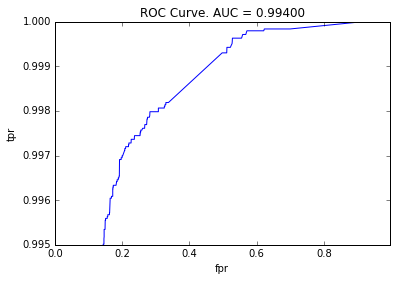

In [23]:
plot_roc(fpr, tpr, auc_score)

In [25]:
from sklearn.metrics import precision_recall_curve

precision, recall, pcrt = precision_recall_curve(y_true, data['predict_proba'])
pcrt = np.insert(pcrt, 0, 0)
pcrt = 1 - pcrt

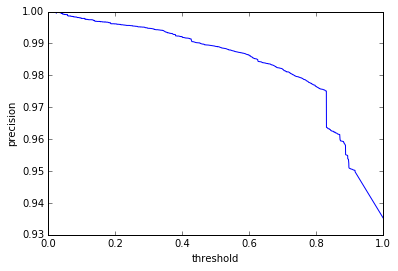

In [26]:
plt.figure()
plt.plot(pcrt, precision)
plt.xlabel('threshold')
plt.ylabel('precision')

(0.9, 1.0)

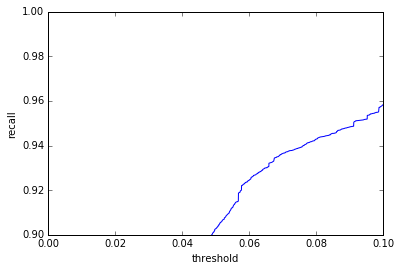

In [27]:
plt.figure()
plt.plot(pcrt, recall)
plt.xlabel('threshold')
plt.ylabel('recall')
plt.xlim([0.0, 0.1])
plt.ylim([0.9, 1.0])

In [29]:
false_negative = data[~data['predict'] & (data['status'] == 1)]
false_negative

,text,status,predict_proba,predict,lang
279,ребят очень нужен донар крови выручите пожалуй...,1,0.373988,False,ru
823,аушева ирина сергеевна лет диагноз острый лимф...,1,0.423145,False,ru
1204,внимание все мои любимые кто в питере нужна лю...,1,0.169955,False,ru
1558,максимальный репост,1,0.425415,False,ru
1768,умираю спасайте нужна сделать перелевание крови,1,0.169955,False,ru
1863,у кого и есть время и желание сдайте кровь,1,0.261559,False,ru
1991,нужно больше крови,1,0.169955,False,ru
2305,завтра с утра сдам кровь для сергея,1,0.327270,False,ru
2465,иду сдавать кровь если кому то нужна пишите да...,1,0.391173,False,ru
2890,доброе утро для вас есть очень нужная информац...,1,0.112430,False,ru


In [30]:
false_positive = data[data['predict'] & (data['status'] == 0)]
false_positive

,text,status,predict_proba,predict,lang
552,кто то говорит они ждут пока иллюминаты усыпят...,0,0.588454,True,ru
592,присоединись к регистру доноров кроветворных с...,0,0.813489,True,ru
666,тромбоцитыыыыы аууууууу вы куда пропали все а ...,0,0.698232,True,ru
707,солдатам нужна кровь эээх скоро моя я отрицате...,0,0.883783,True,ru
970,эх сердечко остановилась у тебя девочка моя ну...,0,0.958347,True,ru
1307,я так радовался когда нашёл своего настоящего ...,0,0.952115,True,ru
1796,ребята моему брату нужна помощь он умирает ему...,0,0.797163,True,ru
1886,путин владимир владимирович вернуть льготы поч...,0,0.574133,True,ru
2090,такие статьи нужно разбирать в школе очень мно...,0,0.534149,True,ru
2355,алтуфан привет завтра в центре соцобслуживания...,0,0.687324,True,ru


In [104]:
from dill import dill

with open('model/voting/vectorizer.pkl', 'wb') as f:
    dill.dump(vectorizer, f)

with open('model/voting/model.pkl', 'wb') as f:
    dill.dump(model, f)